<h1>Predicting Student performance</h1>
<br>
Data : https://archive.ics.uci.edu/ml/datasets/Student+Performance

<h4>Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:</h4>

<ol type="1">
<li>school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
<li>sex - student's sex (binary: "F" - female or "M" - male)
<li>age - student's age (numeric: from 15 to 22)
<li>address - student's home address type (binary: "U" - urban or "R" - rural)
<li>famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
<li>Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
<li>Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
<li>Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
<li>Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
<li>Fjob - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
<li>reason - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
<li>guardian - student's guardian (nominal: "mother", "father" or "other")
<li>traveltime - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
<li>studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
<li>failures - number of past class failures (numeric: n if 1<=n<3, else 4)
<li>schoolsup - extra educational support (binary: yes or no)
<li>famsup - family educational support (binary: yes or no)
<li>paid - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
<li>activities - extra-curricular activities (binary: yes or no)
<li>nursery - attended nursery school (binary: yes or no)
<li>higher - wants to take higher education (binary: yes or no)
<li>internet - Internet access at home (binary: yes or no)
<li>romantic - with a romantic relationship (binary: yes or no)
<li>famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
<li>freetime - free time after school (numeric: from 1 - very low to 5 - very high)
<li>goout - going out with friends (numeric: from 1 - very low to 5 - very high)
<li>Dalc - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
<li>Walc - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
<li>health - current health status (numeric: from 1 - very bad to 5 - very good)
<li>absences - number of school absences (numeric: from 0 to 93)

<h4>These grades are related with the course subject, Math or Portuguese:</h4>

<li>G1 - first period grade (numeric: from 0 to 20)
<li>G2 - second period grade (numeric: from 0 to 20)
<li>G3 - final grade (numeric: from 0 to 20, output target)

Additional note: there are several (382) students that belong to both datasets . 
These students can be identified by searching for identical attributes
that characterize each student.

In [1]:
import os.path

base_dir = os.path.join('data')
input_path_port = os.path.join('student', 'student_port.csv')
input_path_math = os.path.join('student', 'student_math.csv')

file_name_port = os.path.join(base_dir, input_path_port)
file_name_math = os.path.join(base_dir, input_path_math)

filtered_port = sc.textFile(file_name_port).filter(lambda l: 'school' not in l)
filtered_math = sc.textFile(file_name_math).filter(lambda l: 'school' not in l)

print 'Count : ' + str(filtered_port.count())
print filtered_port.take(1)
print 'Count : ' + str(filtered_math.count())
print filtered_math.take(1)

Count : 649
[u'"GP";"F";18;"U";"GT3";"A";4;4;"at_home";"teacher";"course";"mother";2;2;0;"yes";"no";"no";"no";"yes";"yes";"no";"no";4;3;4;1;1;3;4;"0";"11";11']
Count : 395
[u'"GP";"F";18;"U";"GT3";"A";4;4;"at_home";"teacher";"course";"mother";2;2;0;"yes";"no";"no";"no";"yes";"yes";"no";"no";4;3;4;1;1;3;6;"5";"6";6']


In [2]:
from pyspark.mllib.regression import LabeledPoint

def make_features(line):
    raw_features = line.split(';')
    features = []
    if int(raw_features[32]) > 10:
        lbl = 1
    else:
        lbl = 0
    # Female = [0, 1], Male = [1, 0]
    features.extend([0, 1] if raw_features[1] == '"F"' else [1, 0])
    # Age
    features.append(int(raw_features[2]))
    # Family size < 3 = 0, > 3 = 1
    features.append(0 if raw_features[4] == '"LT3"' else 1)
    # mother education
    features.append(int(raw_features[6]))
    # Father education
    features.append(int(raw_features[7]))
    # Study time
    features.append(int(raw_features[13]))
    # Alcohol consumption
    features.append(int(raw_features[26]))
    
    return LabeledPoint(lbl, features)
    
features_port = filtered_port.map(make_features)
features_math = filtered_math.map(make_features)

print features_port.take(1)
print features_math.take(1)

[LabeledPoint(1.0, [0.0,1.0,18.0,1.0,4.0,4.0,2.0,1.0])]
[LabeledPoint(0.0, [0.0,1.0,18.0,1.0,4.0,4.0,2.0,1.0])]


<h3>Male - Female distribution</h3>

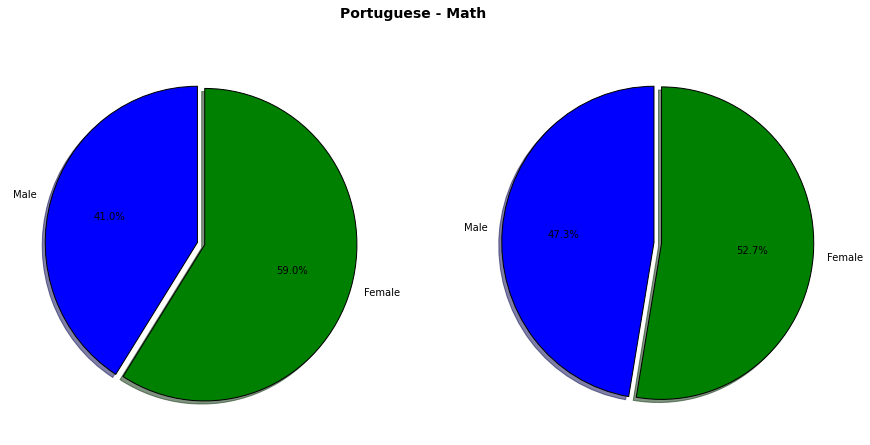

In [3]:
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt
%matplotlib inline

# http://karthik.github.io/2014-02-18-UTS/lessons/thw-matplotlib/tutorial.html

# Portuguese
summary1 = Statistics.colStats(features_port.map(lambda lp: lp.features))
labels = ['Male', 'Female']
fracs1 = [summary1.mean()[0], summary1.mean()[1]]
explode = (0, 0.05)

fig = plt.figure(figsize=(15, 7))
fig.suptitle('Portuguese - Math', fontsize=14, fontweight='bold')
ax1 = fig.add_subplot(121)
ax1.pie(fracs1, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

# Math
summary2 = Statistics.colStats(features_math.map(lambda lp: lp.features))
fracs2 = [summary2.mean()[0], summary2.mean()[1]]

ax2 = fig.add_subplot(122)
ax2.pie(fracs2, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

pass

<h3>Age distribution</h3>

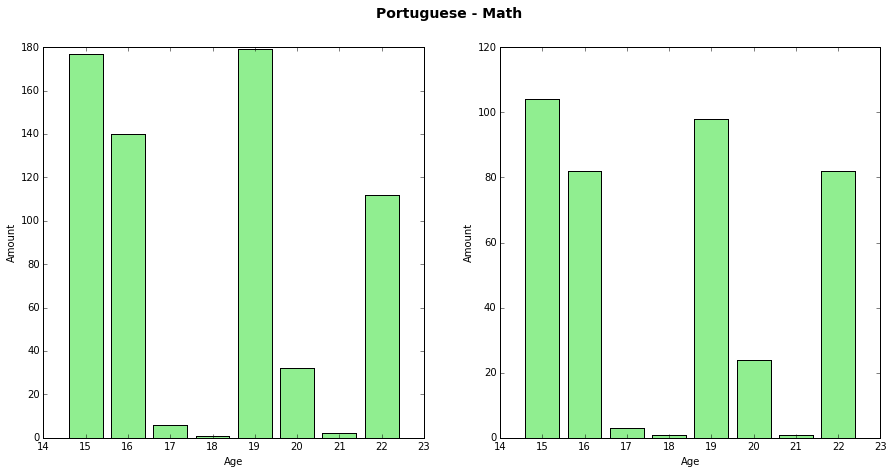

In [4]:
# Portuguese
x_axis_port = [15, 16, 17, 18, 19, 20, 21, 22]
y_axis_port = (features_port
                       .map(lambda lp: (lp.features[2], 1))
                       .reduceByKey(lambda x, y: x + y)
                       .map(lambda tup: tup[1])
                       .collect())

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Age')
ax1.set_ylabel('Amount')
ax1.bar(x_axis_port, y_axis_port, color='lightgreen', align='center')

# Math
x_axis_math = [15, 16, 17, 18, 19, 20, 21, 22]
y_axis_math = (features_math
                       .map(lambda lp: (lp.features[2], 1))
                       .reduceByKey(lambda x, y: x + y)
                       .map(lambda tup: tup[1])
                       .collect())

fig.suptitle('Portuguese - Math', fontsize=14, fontweight='bold')
ax2 = fig.add_subplot(122)
ax2.set_xlabel('Age')
ax2.set_ylabel('Amount')
ax2.bar(x_axis_math, y_axis_math, color='lightgreen', align='center')

pass

<h3>Grade distribution</h3>

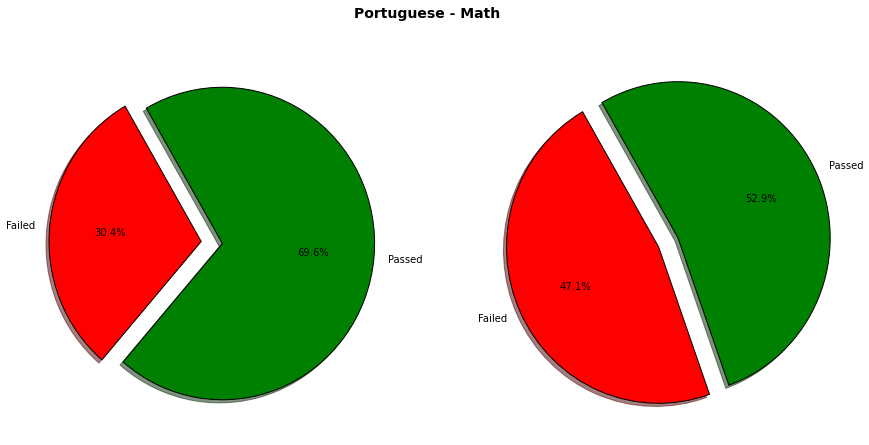

In [5]:
# Portuguese
first_port = features_port.filter(lambda lp: lp.label == 0.0).count()
second_port = features_port.filter(lambda lp: lp.label == 1.0).count()
labels = ['Failed', 'Passed']
fracs1 = [first_port, second_port]
colors = ['red', 'green']
explode = (0.07, 0.07)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
ax1.pie(fracs1, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=120)

# Math
first_math = features_math.filter(lambda lp: lp.label == 0.0).count()
second_math = features_math.filter(lambda lp: lp.label == 1.0).count()
fracs2 = [first_math, second_math]

fig.suptitle('Portuguese - Math', fontsize=14, fontweight='bold')
ax2 = fig.add_subplot(122)
ax2.pie(fracs2, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=120)

pass

In [6]:
import math

# rescale the features by centering
# and dividing by the variance
def rescale(features):
    r = []
    for i, f in enumerate(features):
        c = f - mean.value[i]
        s = c / math.sqrt(variance.value[i]) if c != 0.0 else 0.0
        r.append(s)
    return r

summary1 = Statistics.colStats(features_port.map(lambda lp: lp.features))
# broadcast as list
mean = sc.broadcast(summary1.mean())
variance = sc.broadcast(summary1.variance())
scaled_features_port = features_port.map(lambda lp: LabeledPoint(lp.label, rescale(lp.features)))

summary2 = Statistics.colStats(features_math.map(lambda lp: lp.features))
# broadcast as list
mean = sc.broadcast(summary2.mean())
variance = sc.broadcast(summary2.variance())
scaled_features_math = features_math.map(lambda lp: LabeledPoint(lp.label, rescale(lp.features)))

print scaled_features_port.take(1)
print scaled_features_math.take(1)

[LabeledPoint(1.0, [-0.946975403482,0.946975403482,1.02175063829,0.0,1.14240683802,1.35864755658,-0.0422322855734,-0.540013794192])]
[LabeledPoint(0.0, [-0.946975403482,0.946975403482,1.02175063829,0.0,1.14240683802,1.35864755658,-0.0422322855734,-0.540013794192])]


<h3>SVM</h3>

<h4>Portuguese</h4>

In [7]:
from sklearn import svm

def eval_metrics(lbl_pred):
    tp = float(lbl_pred.filter(lambda lp: lp[0]==1.0 and lp[1]==1.0).count())
    tn = float(lbl_pred.filter(lambda lp: lp[0]==0.0 and lp[1]==0.0).count())
    fp = float(lbl_pred.filter(lambda lp: lp[0]==1.0 and lp[1]==0.0).count())
    fn = float(lbl_pred.filter(lambda lp: lp[0]==0.0 and lp[1]==1.0).count())
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F_measure = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return([tp, tn, fp, fn], [precision, recall, F_measure, accuracy])

In [8]:
train_port, test_port = scaled_features_port.randomSplit([0.7, 0.3], seed = 0)
labels = train_port.map(lambda lp: lp.label).collect()
features = train_port.map(lambda lp: lp.features).collect()

lin_clf = svm.LinearSVC()
lin_clf.fit(features, labels) 
labels_and_predictions = test_port.map(lambda lp: (lin_clf.predict(lp.features), lp.label))
metrics = eval_metrics(labels_and_predictions)

print('Precision : %.2f' % round(metrics[1][0], 2))
print('Recall : %.2f' % round(metrics[1][1], 2))
print('F1 : %.2f' % round(metrics[1][2], 2))
print('Accuracy : %.2f' % round(metrics[1][3], 2))

Precision : 0.72
Recall : 0.93
F1 : 0.81
Accuracy : 0.70


<h4>Math</h4>

In [9]:
train_math, test_math = scaled_features_math.randomSplit([0.7, 0.3], seed = 0)
labels = train_math.map(lambda lp: lp.label).collect()
features = train_math.map(lambda lp: lp.features).collect()

lin_clf = svm.LinearSVC()
lin_clf.fit(features, labels) 
labels_and_predictions = test_math.map(lambda lp: (lin_clf.predict(lp.features), lp.label))
metrics = eval_metrics(labels_and_predictions)

print('Precision : %.2f' % round(metrics[1][0], 2))
print('Recall : %.2f' % round(metrics[1][1], 2))
print('F1 : %.2f' % round(metrics[1][2], 2))
print('Accuracy : %.2f' % round(metrics[1][3], 2))

Precision : 0.65
Recall : 0.66
F1 : 0.65
Accuracy : 0.60


<h3>Naive Bayes</h3>

<h4>Portuguese</h4>

In [10]:
from pyspark.mllib.classification import NaiveBayes

# Naive Bayes expects positive 
# features, so we square them
def square(feat):
    r = []
    for x in feat:
        r.append(x ** 2)
    return r

train_port, test_port = scaled_features_port.randomSplit([0.7, 0.3], seed = 0)
squared_train_data = train_port.map(lambda lp: LabeledPoint(lp.label, square(lp.features)))
squared_test_data = test_port.map(lambda lp: LabeledPoint(lp.label, square(lp.features)))

model_nb = NaiveBayes.train(squared_train_data)
labels_and_predictions = squared_test_data.map(lambda lp: (model_nb.predict(lp.features), lp.label))
metrics = eval_metrics(labels_and_predictions)

print('Precision : %.2f' % round(metrics[1][0], 2))
print('Recall : %.2f' % round(metrics[1][1], 2))
print('F1 : %.2f' % round(metrics[1][2], 2))
print('Accuracy : %.2f' % round(metrics[1][3], 2))

Precision : 0.70
Recall : 0.93
F1 : 0.79
Accuracy : 0.67


<h4>Math</h4>

In [11]:
train_math, test_math = scaled_features_math.randomSplit([0.7, 0.3], seed = 0)
squared_train_data = train_math.map(lambda lp: LabeledPoint(lp.label, square(lp.features)))
squared_test_data = test_math.map(lambda lp: LabeledPoint(lp.label, square(lp.features)))

model_nb = NaiveBayes.train(squared_train_data)
labels_and_predictions = squared_test_data.map(lambda lp: (model_nb.predict(lp.features), lp.label))
metrics = eval_metrics(labels_and_predictions)

print('Precision : %.2f' % round(metrics[1][0], 2))
print('Recall : %.2f' % round(metrics[1][1], 2))
print('F1 : %.2f' % round(metrics[1][2], 2))
print('Accuracy : %.2f' % round(metrics[1][3], 2))

Precision : 0.54
Recall : 0.57
F1 : 0.55
Accuracy : 0.47
